# Workshop 8: Recurrent Neural Networks


This week we will be looking at recurrent neural networks, for processing sequential inputs. The workshop is based on the [Pytorch RNN Tutorial, by Sean Robertson](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). **Please start by reviewing the tutorial,** which builds a model for detecting nationality from a persons surname (a string), using a recurrent neural network. It has a lot more detailed descriptions of each of the steps, especially in terms of the use of the pytorch API.

The code from the tutorial is replicated below, with a few modifications. In the workshop, we'll be moving from a simple RNN to a GRU (a more advanced variant, similar to the LSTM), and develop a model including attention. 

First, we will develop a RNN largely following the tutorial.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

First, load the data files. We truncate the dataset during loading, so that the neural network training steps below run a little faster. 

**Before running the code below, you will first need to download the datafile from [here](https://download.pytorch.org/tutorial/data.zip) and extract it into the current directory.**

In [2]:
def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    random.shuffle(lines)
    lines = lines[:50] # prune the dataset to speed up training
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The next step converts lines, which are strings of characters, into tensors. Please see the tutorial for an explanation of how each character is rendered as a 1-hot vector, and these are packaged together into a tensor.

In [3]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

Now we implement the recurrent step in the RNN model. The idea is that we repeatedly call the `RNN.forward` function to unroll the network over a sequence. Each `hidden` state will be reused as input to the next call to the function. The final `output` vector will be used as part of the loss function.

Compared to the PyTorch tutorial, we've added a non-linear activation function (a tanh) and changed the way in which the output layer is connected to the recurrent unit.

In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size) # changed input
        self.activation = nn.Tanh() # new
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.activation(self.i2h(combined)) # changed to use activation
        output = self.h2o(hidden) # changed input
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training

We will now create a method `randomTrainingExample` which grabs a labelled instance from the training set, processes this into a tensor, and returns the result. We have added one wrinkle compared to the tutorial, namely we make the strings more complex by appending some punctuation characters. These are (mostly) meaningless, and the model can easily learn to skip over these inputs. However they will make learning more complex, and we will be assessing how robust training is when using different lengths of suffix, and how this changes with the use of the different architectures.

In [5]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(noise=0, noise_chars=".,;'"):
    # noise: integer denoting the maximum number of distractor characters to add
    # noise_chars: inventory of distractor characters
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    # added code to insert distracting nonsense into the string
    if noise > 0:
        line_prime = line
        for i in range(random.randint(0, noise+1)):
            line_prime += random.choice(noise_chars)
        line = line_prime
    # end change
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

Let's test the new function to ensure it behaves as expected.

In [6]:
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample(5)
    print('category =', category, '/ line =', line)

category = Italian / line = Agresta,,''
category = Czech / line = Weichert;,
category = Spanish / line = Pena
category = French / line = Marion,''
category = Dutch / line = Aarle'


Notice how instances are names with a short burst of punctuation appended to the end. This will form the training instances, and the category will serve as the target label.

We'll now set the key variables for training. Note that we have added a `noise_level` variable, which we can use to increase the difficult of the dataset. Let's start with the clean data, that is with `noise_level=0`. 

In [7]:
n_iters = 80000
print_every = 5000
plot_every = 1000
noise_level = 0 # change this line (as discussed later)
n_hidden = 32
learning_rate = 0.005

The training loop below takes 2 minutes to complete 80000 SGD updates, so please be patient! You may be wondering about the training loop, which is a bit different to the normal presentation of SGD. Namely the training loop isn't structured into 'epochs' with data shuffling in each epoch, but instead proceeds a fixed number of updates with random sampling of data in each step. This is an alternative for the purpose of simplicity of exposition, and makes little difference to training. In practise, we tend to use the former method, with explicit epochs on real machine learning datasets.

In [8]:
current_loss = 0
all_losses = []

rnn = RNNClassifier(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

# training algorithm, which takes one instance and performs single SGD update
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    # key step: unroll the RNN over each symbol in the input sequence
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # treat the last output as the prediction of the category label
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 6% (0m 1s) 2.8275 Hew / French ✗ (Chinese)
10000 12% (0m 3s) 2.3538 Devin / Russian ✗ (Irish)
15000 18% (0m 4s) 2.1708 Wood / Korean ✗ (Scottish)
20000 25% (0m 6s) 2.1749 Strobel / Dutch ✗ (German)
25000 31% (0m 7s) 0.0832 Dubatkov / Russian ✓
30000 37% (0m 9s) 1.1025 Sze  / Korean ✗ (Chinese)
35000 43% (0m 10s) 3.4385 Maurice / French ✗ (Irish)
40000 50% (0m 12s) 1.8361 Quinones / French ✗ (Spanish)
45000 56% (0m 13s) 1.5871 Krol / Scottish ✗ (Polish)
50000 62% (0m 14s) 0.5116 Lieu / Vietnamese ✓
55000 68% (0m 16s) 0.2780 Meszes / Czech ✓
60000 75% (0m 17s) 0.1210 Kafka / Czech ✓
65000 81% (0m 19s) 0.2140 Shamoun / Arabic ✓
70000 87% (0m 20s) 1.7351 Crespo / Portuguese ✗ (Spanish)
75000 93% (0m 21s) 0.0453 Reynders / Dutch ✓
80000 100% (0m 23s) 0.5547 Yeo / Korean ✓


We now plot the loss values, which shows progress of training. Note that in most ML settings we care about generalisation error, and thus would look at performance on a heldout testing set. But for the purpose of this tutorial, we will focus on training, in terms of how efficiently RNN models can be trained.

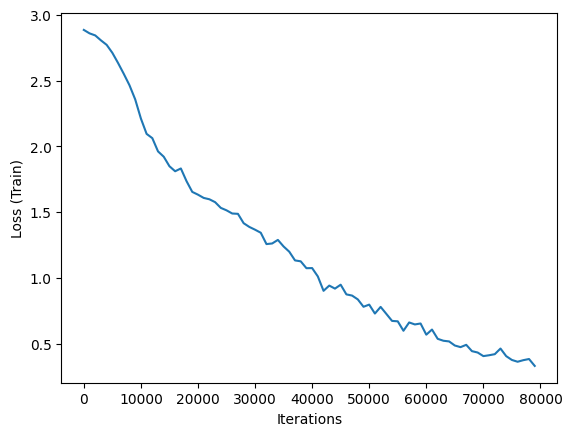

In [9]:
plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Loss (Train)')
plt.plot(range(0,n_iters,plot_every),all_losses)

## GRU recurrent unit

Next we consider a more advanced hidden unit, namely the ["gated recurrent unit" or GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit). This unit includes a linear recurrent dynamic over the hidden state, which allows for better gradient behaviour when using back propagation. Namely there is less of an issue with gradient vanishing. This functions in largely a similar way to the long short term memory unit (LSTM), but is a little simpler and faster to compute.

In the following, ensure you reset `noise_level=0`.

First we will define a GRU classifier, which encodes an input sequence with a GRU, then uses the final hidden state to generate a multiclass output class.

In [10]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size) 
    def forward(self, input_sequence):
        # apply GRU to full input sequence, and retain final hidden state
        _, hidden = self.gru(input_sequence)
        # couple final hidden state to multiclass classifier, i.e., softmax output
        output = self.h2o(hidden.view(1, -1)) 
        output = F.log_softmax(output, dim=1)
        return output

As we are applying the GRU to full sequences, we will tinker with the training loop to accomodate this change. We will also use some more of the pytorch functionality, namely an explicit `SGD` optimiser object to encapsulate the gradient update routine.

In [11]:
model = GRUClassifier(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

start = time.time()
all_losses_gru = []
current_loss = 0

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)

    model.zero_grad()
    #output = model(line_tensor)
    output = model.forward(line_tensor)
    output = torch.squeeze(output, 1) # remove redundant dimension
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    loss.backward()
    optimizer.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_gru.append(current_loss / plot_every)
        current_loss = 0

5000 6% (0m 2s) 2.8430 Bartlett / Russian ✗ (English)
10000 12% (0m 4s) 2.8653 Guo / Vietnamese ✗ (Chinese)
15000 18% (0m 6s) 2.7181 Martell / Dutch ✗ (Spanish)
20000 25% (0m 9s) 2.0061 Ribeiro / Portuguese ✓
25000 31% (0m 11s) 1.3088 Chung / Chinese ✗ (Korean)
30000 37% (0m 13s) 2.6979 Whyte / German ✗ (Scottish)
35000 43% (0m 15s) 1.5565 Linville / Scottish ✗ (French)
40000 50% (0m 18s) 1.1634 Russell / Scottish ✓
45000 56% (0m 20s) 0.0818 Manoukarakis / Greek ✓
50000 62% (0m 22s) 1.5908 Kalb / English ✗ (German)
55000 68% (0m 24s) 0.3508 O'Mooney / Irish ✓
60000 75% (0m 27s) 0.6269 Flann / Irish ✓
65000 81% (0m 29s) 1.9187 Dzhibladze / Spanish ✗ (Russian)
70000 87% (0m 31s) 1.2970 Hanek / Polish ✗ (Czech)
75000 93% (0m 33s) 0.2703 Marquez / Spanish ✓
80000 100% (0m 36s) 1.5080 Abaza / Russian ✓


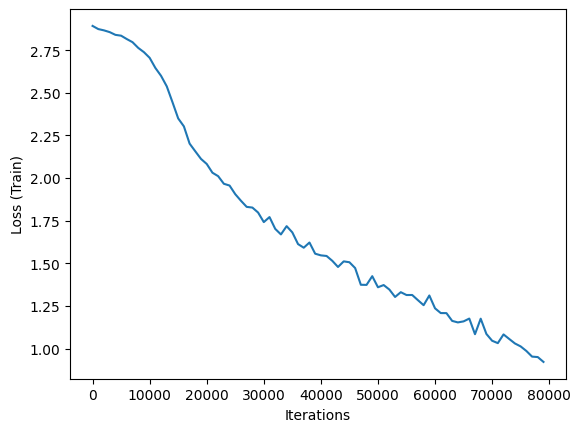

In [12]:
plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Loss (Train)')
plt.plot(range(0,n_iters,plot_every),all_losses_gru)

## Attentional model

Lastly, we will add an attentional component to the GRU model. This is designed to allow the use of hidden states besides the final state in parameterising the classifier. We will formulation attention as follows:

\begin{align}
e_j & = f(\mathbf{h}_j) \\
\alpha_j & = \frac{\exp(e_j)}{\sum_k \exp(e_k)} \\
\mathbf{c} & = \sum_j \alpha_j \mathbf{h}_j
\end{align}

where $f()$ is a linear function of its input vector, and the resulting $\mathbf{c}$ is then used as input into the final linear classifier. Each component has the following role:
- $\mathbf{e}$: unnormalised attention scores, one value for each item in the input sequence
- $\mathbf{\alpha}$: normalised attention scores, which can be interpreted as probabilities over the sequence of inputs (a.k.a. the *attention* vector)
- $\mathbf{c}$: a weighted combination of hidden states, based on the attention vector

In [13]:
class AttentionalGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AttentionalGRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size) 
        self.att = nn.Linear(hidden_size, 1) 
        
    def forward(self, input_sequence):
        # process the input sequence into a sequence of RNN hidden states
        states, _ = self.gru(input_sequence)
        # compute attention scores to each RNN hidden state (we use a linear function)
        att_scores = self.att(states)
        # rescale the attention scores using a softmax, so they sum to one
        alpha = F.softmax(att_scores, dim=0)
        # compute the "c" vector as a weighted combination of the RNN hidden states
        c = torch.sum(torch.mul(states, alpha), dim=0)
        # now couple up the c state to the output, and compute log-softmax
        output = self.h2o(c.view(1, -1)) 
        output = F.log_softmax(output, dim=1)
        return output, alpha

The training loop is the same as above, just using the new model class.

In [ ]:
model = AttentionalGRUClassifier(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

start = time.time()
all_losses_att = []
current_loss = 0

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)

    model.zero_grad()
    output, _ = model.forward(line_tensor)
    output = torch.squeeze(output, 1) # remove redundant dimension
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    loss.backward()
    optimizer.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_att.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
plt.figure()
plt.plot(range(0,n_iters,plot_every),all_losses, label='rnn')
plt.plot(range(0,n_iters,plot_every),all_losses_gru, label='gru')
plt.plot(range(0,n_iters,plot_every),all_losses_att, label='gru+attention')
plt.xlabel('Iterations')
plt.ylabel('Loss (Train)')
plt.legend()

**Discussion**: How do all three methods compare in terms of their efficiency of training? Is there a good empirical reason to use the GRU or attentional model over the vanilla RNN?

Now rerun all of the above models with `noise_level=5`. 

---
**Discussion**: Are the loss values higher or lower after this change? Can you explain why?

**Discussion**: Do your conclusions about the three models change, based on training on the noisy dataset? Why?

---

### Inspecting the Attention

Finally, we can investigate how the attention is used. The code below shows some data instances and the computed attention vector. 

In [ ]:
with torch.no_grad():
    for i in range(5):
        category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)
        output, attention = model.forward(line_tensor)
        print(line, category, ['{:.2f}'.format(a) for a in attention.numpy().flatten()])

Most of the attention is focussed on the last item in the sequence (when `noise_level=0`). 

**Question:** Why is this? And does this change when `noise_level=5`?

### Bonus

In this worksheet we have compared models in terms of their ease of training. However the more important test is in terms of generalisation accuracy. Typically when we test the more complex GRU and attentional models we see improvements in testing performance (ensuring they are all adequately trained, of course). Test the above three models by saving a separate set of unseen names from the original dataset to serve as a test set. Do you observe differences in accuracy?

Next, try changing the GRU model above into a LSTM model. You can use `nn.LSTM` to do so, which supports a similar interface to `nn.GRU`. You will need to take special care with the hidden state, which has two components in the LSTM. Note that the LSTM can support several layers, although training may be much slower when using more than one layer. 

Efficient implementations of RNN models typically use much larger batches. Here we use a batch size of 1 for simplicity. But many pytorch operations can be applied over higher dimensional tensors to allow processing of several instances at once. For more insights into this, and other topics in state of the art RNN models, take a look at the tutorials in pytorch, including the one on [transformer models](https://pytorch.org/tutorials/beginner/transformer_tutorial.html).